# Assignment 2 - Problem 3 - Part 1

In [1]:
import numpy as np
import random
from sklearn import cluster
random.seed(42)
np.random.seed(42)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Define the Function to be Approximated

In [3]:
def target_function(x):
    """x is a pair of values -(x1, x2)"""
    x1, x2 = x
    if x1**2+x2**2 <= 1: return 1
    else: return -1

### Define the RBF Network and the Dataset

In [4]:
class RBFNet:
    """
    RBF Network has three layers, the input, the hidden, and the
    output.
    
    The hidden layer is a non-linear activation function and 
    used with gaussian kernel
    """
    def __init__(self, centers, sigma):
        self.centers = centers
        self.sigma = sigma
        self.output_dim = 1
        self.weights = np.zeros((len(centers), self.output_dim))
    
    def gaussian_kernel(self, data):
        """gaussian kernel function"""
        return np.exp(-np.linalg.norm(data-self.centers, axis=1)**2 / (2 * self.sigma**2))
    
    def set_weights(self, data, targets):
        """
        as the network is used for interpolation, we calculate
        the interpolation matrix and then use psudoinverse method
        to solve for the weight matrix
        """
        G = []
        # calculate interpolation matrix
        for point in data:
            g = self.gaussian_kernel(point)
            G.append(g)
        G = np.asarray(G)
        # apply psudoinverse method
        G = np.linalg.pinv(G)
        W = G.dot(targets)
        self.weights = W
        
    def fit(self, point):
        """calculate the hidden layer output for a single point"""
        hidden = self.gaussian_kernel(point)
        return np.dot(hidden, self.weights)
    
    def batch_fit(self, points):
        """calculate the hidden output for all data points"""
        return np.asarray([self.fit(pt) for pt in points])
    
    def predict(self, points):
        """generate predictions"""
        preds = self.batch_fit(points)
        preds[preds >= 0] = 1
        preds[preds < 0] = -1
        return preds
    
    def compute_mse(self, pred, target):
        return np.mean((pred-target)**2)

class RBFData:
    """create the data for the RBF Network"""
    def __init__(self, data_range, split_ratio):
        # the range of i and j is from 0 to 20
        self.data_range = data_range
        # the ratio used to split train/test sets
        self.split_ratio = split_ratio
    
    def generate_data(self):
        data = []
        # generating data
        for i in range(self.data_range):
            for j in range(self.data_range):
                data.append([-2+0.2*i, -2+0.2*j])
        data = np.asarray(data)
        np.random.shuffle(data)
        # calculate a threshold to split data into train/test
        threshold = int(len(data) * self.split_ratio)
        
        train = data[:threshold,:]
        test = data[threshold:,:]
        
        # create the label with the function that we
        # would like approximate
        train_target = np.zeros((len(train)))
        test_target = np.zeros((len(test)))
        
        for i, pt in enumerate(train):
            train_target[i] = target_function(pt)
        for i, pt in enumerate(test):
            test_target[i] = target_function(pt)
        
        print(f"number of train data: {len(train)}")
        print(f"number of test data: {len(test)}")
        
        return train, test, train_target, test_target

In [5]:
dataset = RBFData(21, 0.8)
tr, tst, tr_gt, tst_gt = dataset.generate_data()

number of train data: 352
number of test data: 89


### Evaluate the Network on Various Spread Parameters

In [6]:
# generate a list of sigma to evaluate the model's performance
sigmas = np.linspace(0.02, 20, 50).tolist()

# set all the training data as the centers
def train_fn(centers, sigma, tr, tr_gt, tst, tst_gt):
    
    result = {
        "train_mse": [],
        "train_acc": [],
        "test_acc": [],
        "sigma": []
    }
    # iterate over all the sigmas in the sigma list
    for s in sigma:
        net = RBFNet(centers, s)
        # calculate the weights
        net.set_weights(tr, tr_gt)
        # forward pass for train set data
        tr_preds = net.batch_fit(tr)
        # forward pass for test set data
        tst_preds = net.batch_fit(tst)
        # calculate the mean square error for the training data
        tr_error = net.compute_mse(tr_preds, tr_gt)
        # generate the predictions for both train/test
        # for evaluating the train/test accuracy
        tr_expected = net.predict(tr)
        tst_expected = net.predict(tst)

        tr_accuracy = np.sum(tr_expected == tr_gt) / tr_expected.size
        tst_accuracy = np.sum(tst_expected == tst_gt) / tst_expected.size

        result['train_mse'].append(tr_error)
        result['train_acc'].append(tr_accuracy)
        result['test_acc'].append(tst_accuracy)
        result['sigma'].append(s)
    return result

In [7]:
result = train_fn(tr, sigmas, tr, tr_gt, tst, tst_gt)

when the sigma is very small, the testing accuracy drops to around 60%. However, when the sigma is larger than (approximately) 2, the testing accuracy is over 90%, and reachs the peak when the sigma is between 4 and 13. The training accuracy is fluctuating along with the increasing of the sigma. When the training accuracy is 100%, the testing accuracy is low, it might be because the model overfits the training data. When sigma increases, the trend of training accuracy is reducing, but the model generalizes to the test set because of the increase of testing accuracy. The mean squared error is increased over time (along with the increase of the sigma). The following 3 figures interpolate the results.

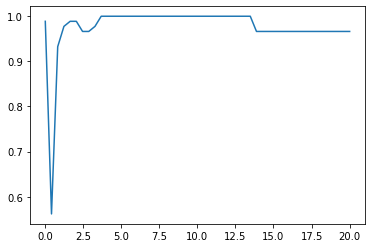

In [8]:
plt.plot(result['sigma'],result['test_acc'])

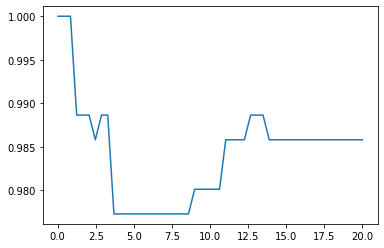

In [9]:
plt.plot(result['sigma'],result['train_acc'])

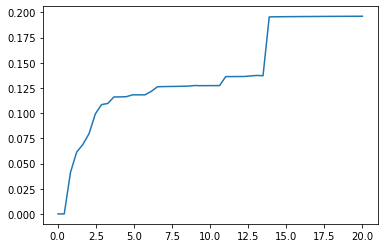

In [10]:
plt.plot(result['sigma'],result['train_mse'])

# Part 2

### Randomly Select 150 Data as Centers

In [11]:
centers = random.choices(tr, k=150)

In [12]:
result_150 = train_fn(centers, sigmas, tr, tr_gt, tst, tst_gt)

When the centers are randomly sampled from the training examples, the testing accuracy changes under the situation that the sigma is unchanged. The sigma on the peak of the testing accuracy is between 3 and 13. It is similar to before (when using all the points as centers). However, the difference is that the average testing accuracy is over 96% and without the gap of low accuracy.

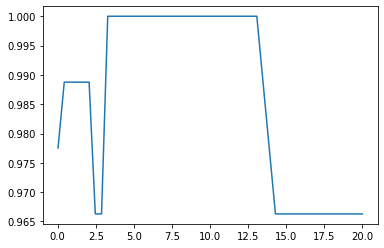

In [13]:
plt.plot(result_150['sigma'],result_150['test_acc'])

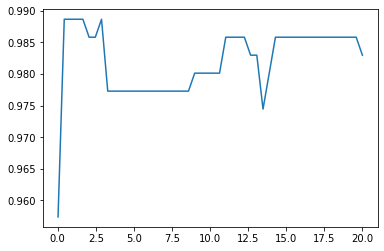

In [14]:
plt.plot(result_150['sigma'],result_150['train_acc'])

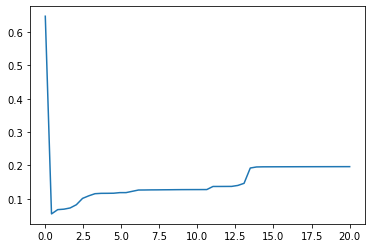

In [15]:
plt.plot(result_150['sigma'],result_150['train_mse'])

### Generates Centers with K-means Clustering

In [16]:
centers = cluster.k_means(tr, n_clusters=150)[0]
result_kmeans = train_fn(centers, sigmas, tr, tr_gt, tst, tst_gt)

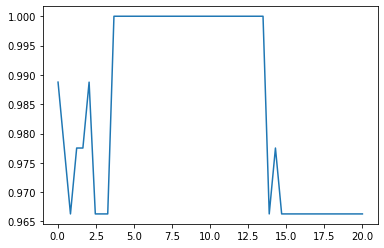

In [17]:
plt.plot(result_kmeans['sigma'],result_kmeans['test_acc'])

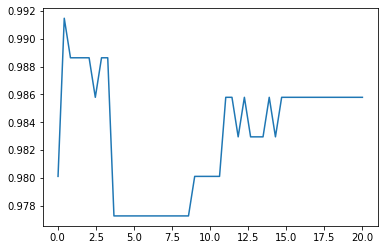

In [18]:
plt.plot(result_kmeans['sigma'],result_kmeans['train_acc'])

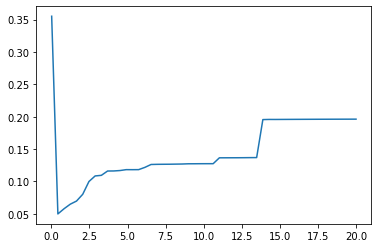

In [19]:
plt.plot(result_kmeans['sigma'],result_kmeans['train_mse'])

The following two figures compare the testing accuracy and the mean squared error in the training phase for the three different methods. We can observe that there is no significant difference when the sigma is large. However, the difference is significant for small sigma.

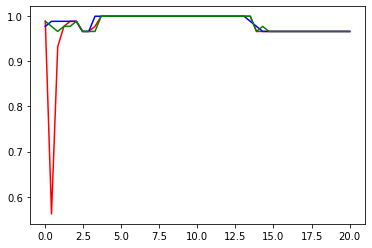

In [20]:
plt.plot(result['sigma'],result['test_acc'], color='r')
plt.plot(result_150['sigma'],result_150['test_acc'], color='b')
plt.plot(result_kmeans['sigma'],result_kmeans['test_acc'], color='g')
plt.show()

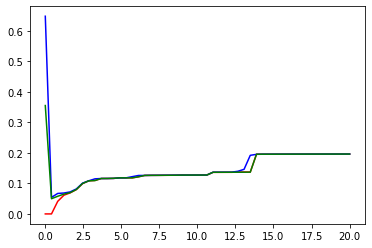

In [21]:
plt.plot(result['sigma'],result['train_mse'], color='r')
plt.plot(result_150['sigma'],result_150['train_mse'], color='b')
plt.plot(result_kmeans['sigma'],result_kmeans['train_mse'], color='g')
plt.show()